# Import libraries

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [46]:
print(tf.__version__)

2.19.0


In [47]:
filename = "data\yes bilder isabelle//2491975_1119775.jpg"

# Train-Test Split
80% - 20%

momentan insgesamt je 80 Bilder --> dh. 64 für Training, 16 Testing

# Loading data

In [48]:
labels = ['no', 'yes'] # yes: green electro parking spot
# 'no' = 0, 'yes' = 1
img_size = 224  # Zielgrösse Bilder           

def get_data(data_dir):
    X = []  # Bilddaten
    y = []  # zugehörigen Labels 0 oder 1 
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]    # Bild einlesen, in RGB umwandeln 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Bild auf einheitliche Grösse skalieren
                X.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(e)
    return np.array(X), np.array(y)

In [49]:
# alle Daten laden 
train_X, train_y = get_data('data/train')   # X=Bild, y=Label 
val_X, val_y = get_data('data/test')        # 0 für no, 1 für yes

print("Train shape:", train_X.shape, train_y.shape)
print("Val shape:", val_X.shape, val_y.shape)
print("\nLabel-Beispiel1:", train_y[0], "→", labels[train_y[0]])
print("Label-Beispiel2:", train_y[-1], "→", labels[train_y[-1]])


print("\nLänge Trainingsdaten:", len(train_X))   # hier 128 Bilder
print("Länge Labels:", len(train_y))   # sollte genauso viele Labels haben wie train_X


Train shape: (128, 224, 224, 3) (128,)
Val shape: (32, 224, 224, 3) (32,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 128
Länge Labels: 128


# Visualize data

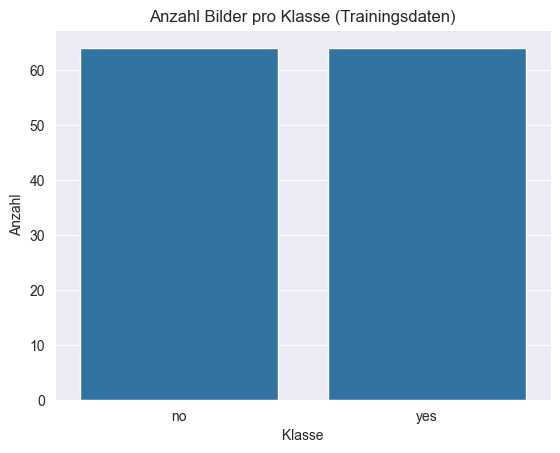

In [50]:
l = []
for i in train_y:   # train_y sind Labels 0 oder 1 
    if i == 0:
        l.append("no")
    else:
        l.append("yes")
        
sns.set_style('darkgrid')
sns.countplot(x=l)
plt.title("Anzahl Bilder pro Klasse (Trainingsdaten)")
plt.xlabel("Klasse")
plt.ylabel("Anzahl")
plt.show()

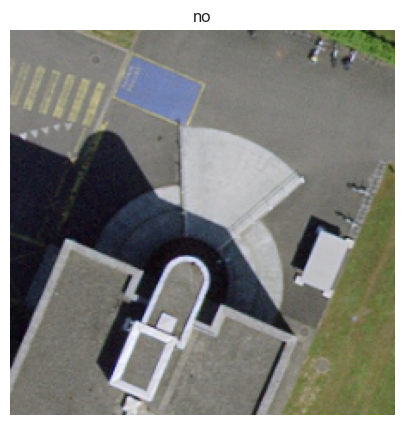

In [51]:
plt.figure(figsize = (5,5))
plt.imshow(train_X[0])  # Bilddaten, hier z.B. erstes Bild 
plt.title(labels[train_y[0]])   # Klassentext: yes or no 
plt.axis('off')
plt.show()

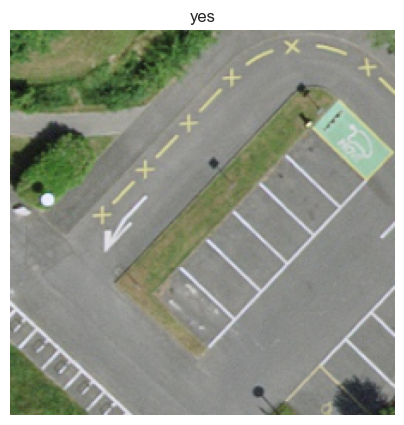

In [52]:
plt.figure(figsize=(5, 5))
plt.imshow(train_X[64]) # 65. Bild im Datensatz = 1. yes Bild 
plt.title(labels[train_y[-1]])  # Label anzeigen: yes or no 
plt.axis('off')
plt.show()

# Data Preprocessing and Data Augmentation 

In [53]:
# Normalisieren --> Pixelwerte von 0-255 enspricht 0-1
x_train = train_X / 255.0
x_val = val_X / 255.0

# Labels in Array umwandeln 
y_train = np.array(train_y)
y_val = np.array(val_y)

print("Train X:", x_train.shape)
print("Train y:", y_train.shape)
print("Val X:", x_val.shape)
print("Val y:", y_val.shape)

Train X: (128, 224, 224, 3)
Train y: (128,)
Val X: (32, 224, 224, 3)
Val y: (32,)


In [54]:
# Data Augmentation für Trainingsdaten
datagen = ImageDataGenerator(   # erstellt zufällige Varianten der Trainingsbilder 
    rotation_range = 30,    # Bilder leicht drehen um Winkel 
    zoom_range = 0.2,       # reinzoomen 
    width_shift_range = 0.1,    # horizontal verschieben 
    height_shift_range = 0.1,   # vertikal verschieben
    horizontal_flip = False,     # spiegeln
    vertical_flip = True       # nicht auf den Kopf stellen
)

datagen.fit(x_train)

# Define the Model

In [55]:
model = Sequential()

# 1. Convolutional Layer 
model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

# 2. Convolutional Layer 
model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
model.add(MaxPool2D())

# 3. Convolutional Layer + Dropout gegen Overfitting 
model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

# Dense Schichten 
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))   # sigmoid für Binary Classification 

model.summary()     # Modellübersicht 

C:\Users\isabe\Studium\green_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,451,425 (24.61 MB)

 Trainable params: 6,451,425 (24.61 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Optimizer 
opt = Adam(learning_rate=0.0001)   # Lernrate gibt an wie stark Modell seine Gewichte anpasst 

# Modell kompilieren 
model.compile(
    optimizer = opt, 
    loss = 'binary_crossentropy',   # für 2-Klassen Probleme 
    metrics = ['accuracy'])

# Training 
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),  # Modell sieht 32 Bilder auf einmal 
    epochs = 50,    # max. 50 Runden 
    validation_data = (x_val, y_val),   # für Modellbewertung 
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]  # beendet Training, wenn sich val_loss 5 Epochen lang nicht mehr verbessert -> verhindert Overfitting 
)


C:\Users\isabe\Studium\green_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 928ms/step - accuracy: 0.4844 - loss: 0.7193 - val_accuracy: 0.5000 - val_loss: 0.7287
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 853ms/step - accuracy: 0.5052 - loss: 0.7542 - val_accuracy: 0.5000 - val_loss: 0.6984
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 817ms/step - accuracy: 0.5771 - loss: 0.6874 - val_accuracy: 0.5000 - val_loss: 0.6903
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 808ms/step - accuracy: 0.4969 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 824ms/step - accuracy: 0.5073 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6882
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 841ms/step - accuracy: 0.5104 - loss: 0.6922 - val_accuracy: 0.7500 - val_loss: 0.6875
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 814ms/step - accuracy: 0.6229 - loss: 0.6873 - val_accuracy: 0.5938 - val_loss: 0.6877
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 793ms/step - accuracy: 0.6198 - loss: 0.6870 - val_accuracy: 0.5625 - val_loss:

# Evaluating results

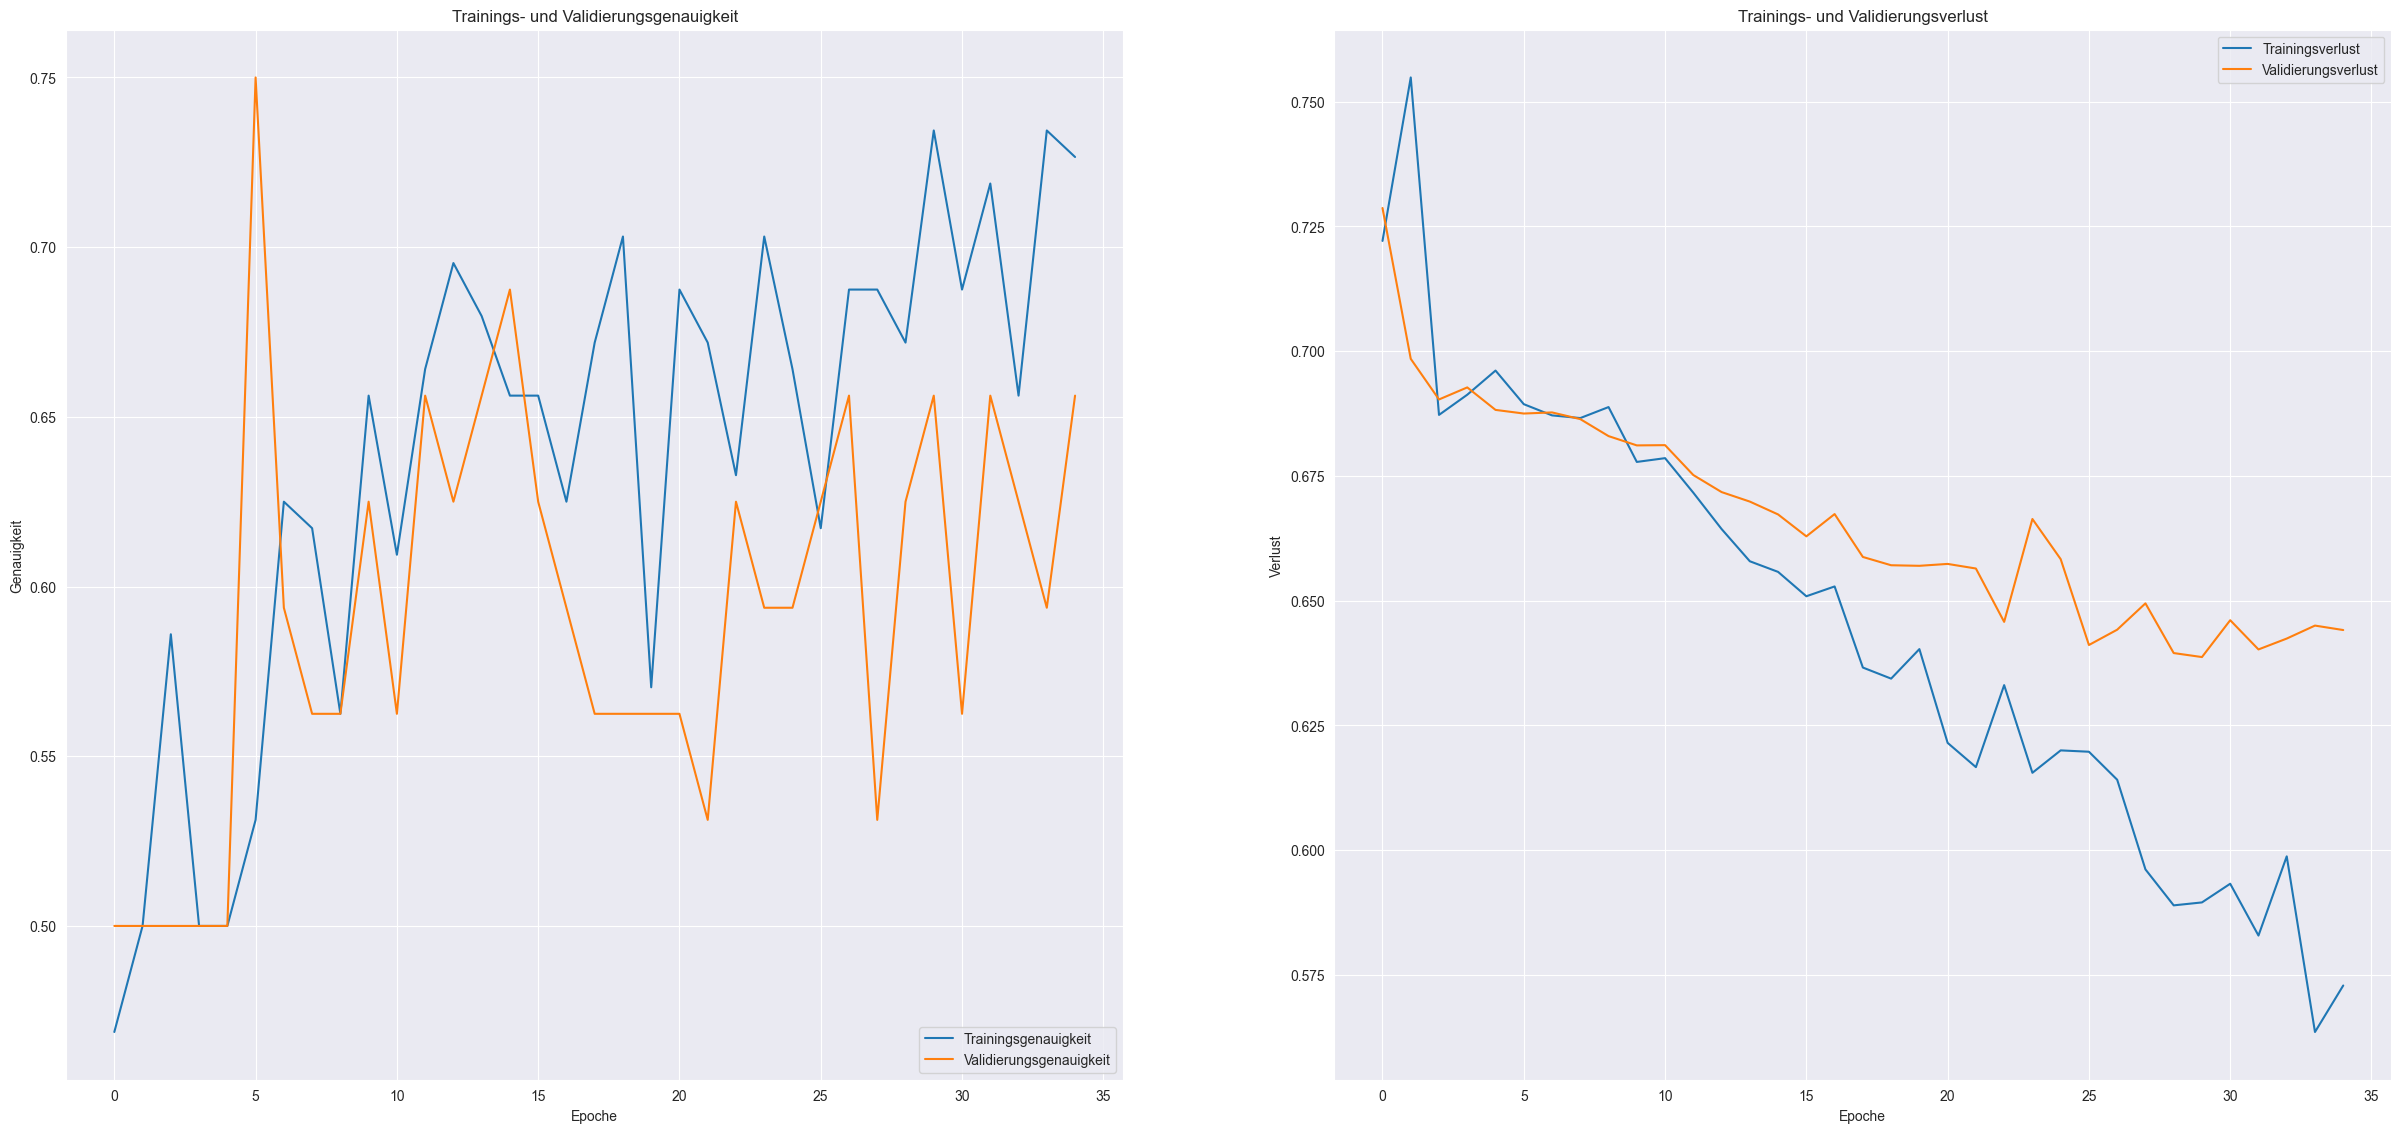

In [58]:
import matplotlib.pyplot as plt

# Trainingsverlauf aus dem History-Objekt auslesen
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Automatisch richtige Länge der x-Achse
epochs_range = range(len(acc))

# Plot erstellen
plt.figure(figsize=(30, 30))

# Accuracy-Plot
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Trainingsgenauigkeit')
plt.plot(epochs_range, val_acc, label='Validierungsgenauigkeit')
plt.legend(loc='lower right')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')

# Loss-Plot
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Trainingsverlust')
plt.plot(epochs_range, val_loss, label='Validierungsverlust')
plt.legend(loc='upper right')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')

plt.show()


In [59]:
# Vorhersagen (Wahrscheinlichkeiten zwischen 0 und 1)
predictions = model.predict(x_val)

# Schwelle: ab 0.5 → Klasse 1 (ja = grüner Parkplatz), sonst Klasse 0
predictions = (predictions > 0.5).astype("int32").reshape(-1)

# Klassifikationsbericht anzeigen
print(classification_report(y_val, predictions, target_names=['kein E-Parkplatz (0)', 'grüner E-Parkplatz (1)']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.69      0.56      0.62        16
grüner E-Parkplatz (1)       0.63      0.75      0.69        16

              accuracy                           0.66        32
             macro avg       0.66      0.66      0.65        32
          weighted avg       0.66      0.66      0.65        32


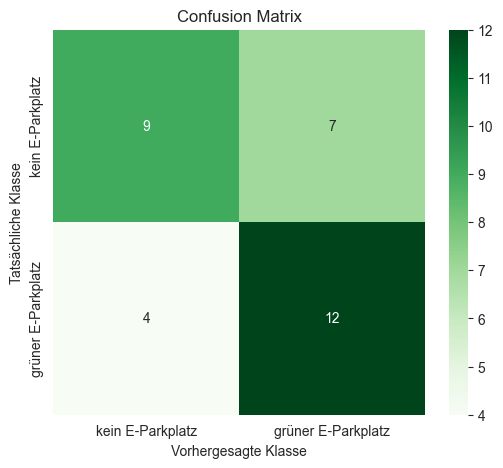

In [63]:
# Confusion Matrix berechnen
cm = confusion_matrix(y_val, predictions)

# Klassenbezeichnungen
labels = ['kein E-Parkplatz', 'grüner E-Parkplatz']

# Plot anzeigen
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Vorhergesagte Klasse')  
plt.ylabel('Tatsächliche Klasse')
plt.title('Confusion Matrix')
plt.show()
# TN    FP
# FN    TP